In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv('train.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


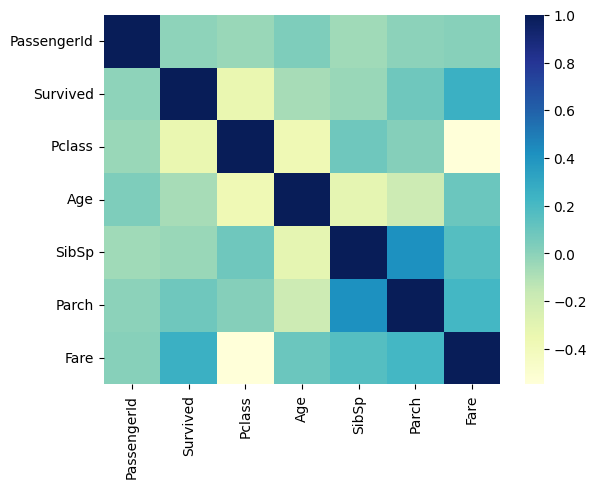

In [3]:
import seaborn as sns

# select only numerical values
numeric_data = titanic_data.select_dtypes(include=[np.number])

sns.heatmap(numeric_data.corr(), cmap='YlGnBu')
plt.show()

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', 'Pclass', 'Sex']]):
    start_train_set = titanic_data.loc[train_indices]
    start_test_set = titanic_data.loc[test_indices]

<Axes: >

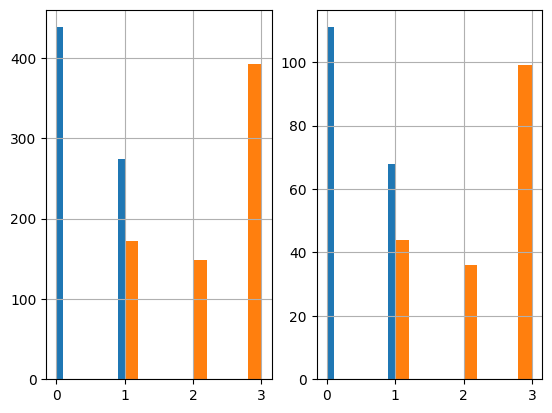

In [5]:
plt.subplot(1, 2, 1) 
start_train_set['Survived'].hist()
start_train_set['Pclass'].hist()

plt.subplot(1, 2, 2) 
start_test_set['Survived'].hist()
start_test_set['Pclass'].hist()

In [6]:
start_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 1 to 166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          567 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        164 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        
        return X

In [8]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        encode = OneHotEncoder()

        # Embarked column
        matrix = encode.fit_transform(X[['Embarked']]).toarray()
        column_names = ['C', 'S', 'Q', 'N']
        for i in  range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        # Sex column
        matrix = encode.fit_transform(X[['Sex']]).toarray()
        column_names = ['Female', 'Male']
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

In [9]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        return self

    def transform(self, X):
        return X.drop(['Embarked', 'Sex', 'Name', 'Ticket', 'Cabin', 'N'], axis=1, errors='ignore')

In [10]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('ageimputer', AgeImputer()),
    ('featureencoder', FeatureEncoder()),
    ('featuredropper', FeatureDropper())
])

In [11]:
start_train_set = pipeline.fit_transform(start_train_set)

In [12]:
start_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
412,413,1,1,33.000000,1,0,90.0000,0.0,1.0,0.0,1.0,0.0
760,761,0,3,29.474868,0,0,14.5000,0.0,0.0,1.0,0.0,1.0
182,183,0,3,9.000000,4,2,31.3875,0.0,0.0,1.0,0.0,1.0
86,87,0,3,16.000000,1,3,34.3750,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117,118,0,2,29.000000,1,0,21.0000,0.0,0.0,1.0,0.0,1.0
330,331,1,3,29.474868,2,0,23.2500,0.0,1.0,0.0,1.0,0.0
727,728,1,3,29.474868,0,0,7.7375,0.0,1.0,0.0,1.0,0.0
498,499,0,1,25.000000,1,2,151.5500,0.0,0.0,1.0,1.0,0.0


In [13]:
start_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 1 to 166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [14]:
from sklearn.preprocessing import StandardScaler

X = start_train_set.drop(['Survived'], axis=1)
Y = start_train_set['Survived']

X_data = StandardScaler().fit_transform(X)
Y_data = Y.to_numpy()
X_data[0]


array([-1.73928587, -1.56828591,  0.66520608,  0.40863336, -0.48163361,
        0.76968006,  2.13600094, -0.31696006, -1.62827579,  1.35941164,
       -1.35941164])

Using random forest classification:

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clk = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000]},
    {'max_depth': [None, 5, 10, 20]},
    {'min_samples_split': [2, 3, 4, 6]}
]

grid_search = GridSearchCV(
    clk,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_data, Y_data)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [10, 100, 200, 500, 1000]},
                         {'max_depth': [None, 5, 10, 20]},
                         {'min_samples_split': [2, 3, 4, 6]}],
             return_train_score=True, scoring='accuracy')

In [16]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=5)

In [17]:
start_test_set = pipeline.fit_transform(start_test_set)

In [18]:
start_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 777 to 132
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Age          179 non-null    float64
 4   SibSp        179 non-null    int64  
 5   Parch        179 non-null    int64  
 6   Fare         179 non-null    float64
 7   C            179 non-null    float64
 8   S            179 non-null    float64
 9   Q            179 non-null    float64
 10  Female       179 non-null    float64
 11  Male         179 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 18.2 KB


In [19]:
X_test = start_test_set.drop(['Survived'], axis=1)
Y_test = start_test_set['Survived']

X_data_test = StandardScaler().fit_transform(X_test)
Y_data_test = Y_test.to_numpy()

In [20]:
final_clf.score(X_data_test, Y_data_test)

0.8268156424581006

In [21]:
final_data = pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [22]:
X_final = final_data.drop(['Survived'], axis=1)
Y_final = final_data['Survived']

X_data_final = StandardScaler().fit_transform(X_final)
Y_data_final = Y_final.to_numpy()

In [23]:
prod_clk = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000]},
    {'max_depth': [None, 5, 10, 20]},
    {'min_samples_split': [2, 3, 4, 6]}
]

grid_search = GridSearchCV(
    prod_clk,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_data_final, Y_data_final)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [10, 100, 200, 500, 1000]},
                         {'max_depth': [None, 5, 10, 20]},
                         {'min_samples_split': [2, 3, 4, 6]}],
             return_train_score=True, scoring='accuracy')

In [24]:
final_prod_clf = grid_search.best_estimator_
final_prod_clf

RandomForestClassifier(max_depth=5)

In [25]:
titanic_test_data = pd.read_csv('test.csv')
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [26]:
titanic_test_data = pipeline.fit_transform(titanic_test_data)

In [27]:
titanic_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [28]:
X_final_test = titanic_test_data
X_final_test = X_final_test.fillna(method='ffill')

X_data_final_test = StandardScaler().fit_transform(X_final_test)

C:\Users\meetp\AppData\Local\Temp\ipykernel_32816\4129418513.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method='ffill')


In [29]:
predictions = final_prod_clf.predict(X_data_final_test)

In [30]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv', index=False)

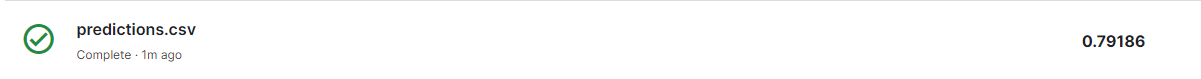

Using Decesion Tree Classification:

array([[-1.73928587e+00, -1.56828591e+00,  6.65206077e-01, ...,
        -1.62827579e+00,  1.35941164e+00, -1.35941164e+00],
       [-1.39005717e-01, -1.56828591e+00,  2.75061939e-01, ...,
        -1.62827579e+00,  1.35941164e+00, -1.35941164e+00],
       [ 1.21597601e+00,  8.27893418e-01, -2.77214083e-16, ...,
         6.14146575e-01, -7.35612358e-01,  7.35612358e-01],
       ...,
       [ 1.08748637e+00,  8.27893418e-01, -2.77214083e-16, ...,
        -1.62827579e+00,  1.35941164e+00, -1.35941164e+00],
       [ 1.95846090e-01, -1.56828591e+00, -3.49168682e-01, ...,
         6.14146575e-01,  1.35941164e+00, -1.35941164e+00],
       [-1.09683763e+00, -1.56828591e+00, -2.77214083e-16, ...,
         6.14146575e-01,  1.35941164e+00, -1.35941164e+00]])

In [38]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_data, Y_data)

DecisionTreeClassifier(random_state=42)

In [39]:
dt_model.score(X_data, Y_data)

1.0

In [40]:
dt_model.score(X_data_test, Y_data_test)

0.7653631284916201

In [45]:
from sklearn.metrics import accuracy_score

y_predicts = dt_model.predict_proba(X_data_test)[:, 1]

new_y = []
for i in range(len(y_predicts)):
  if y_predicts[i] < 0.6:
    new_y.append(0)
  else:
    new_y.append(1)

accuracy_score(Y_data_test, new_y)

0.7653631284916201

In [153]:
# Changing max_depth

train_accuracy = []
test_accuracy = []
for depth in range(1, 40):
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_model.fit(X_data, Y_data)
    train_accuracy.append(dt_model.score(X_data, Y_data))
    test_accuracy.append(dt_model.score(X_data_test, Y_data_test))

In [154]:
print(train_accuracy)
print(test_accuracy)

[0.7865168539325843, 0.7935393258426966, 0.8300561797752809, 0.8426966292134831, 0.8609550561797753, 0.8693820224719101, 0.898876404494382, 0.9115168539325843, 0.9297752808988764, 0.9536516853932584, 0.9648876404494382, 0.9803370786516854, 0.9957865168539326, 0.9971910112359551, 0.9985955056179775, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.7877094972067039, 0.7877094972067039, 0.8268156424581006, 0.7932960893854749, 0.8044692737430168, 0.7932960893854749, 0.7877094972067039, 0.7877094972067039, 0.7653631284916201, 0.7932960893854749, 0.770949720670391, 0.7653631284916201, 0.7541899441340782, 0.7597765363128491, 0.7597765363128491, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 0.7541899441340782, 

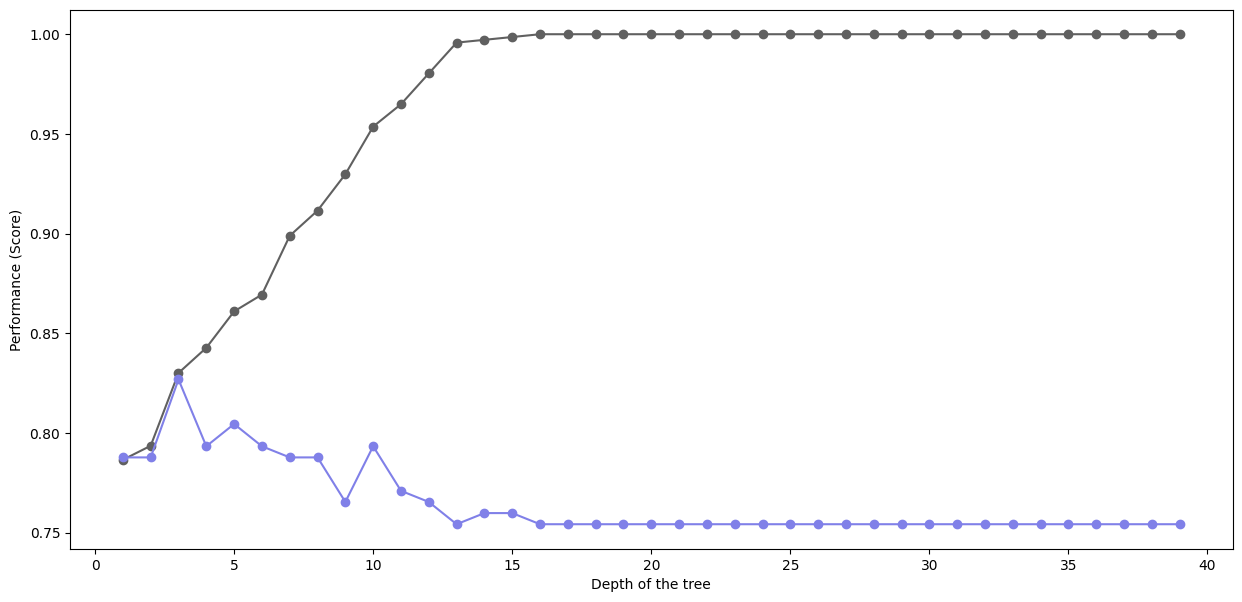

In [156]:
score_df = pd.DataFrame({'max_depth':range(1,40), 'train_acc': train_accuracy, 'test_acc': test_accuracy})

plt.figure(figsize = (15,7))
plt.plot(score_df['max_depth'], score_df['train_acc'], marker = 'o', color = '#606060')
plt.plot(score_df['max_depth'], score_df['test_acc'], marker = 'o', color = '#8080e8')
plt.xlabel('Depth of the tree')
plt.ylabel('Performance (Score)')
plt.show()

In [157]:
print(dt_model.score(X_data, Y_data))
print(dt_model.score(X_data_test, Y_data_test))

1.0
0.7541899441340782


In [159]:
# Changing max_leaf_depth
max_depth = 10

train_accuracy = []
test_accuracy = []
for depth in range(2, 42):
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth, max_leaf_nodes=depth, random_state=156)
    dt_model.fit(X_data, Y_data)
    train_accuracy.append(dt_model.score(X_data, Y_data))
    test_accuracy.append(dt_model.score(X_data_test, Y_data_test))

In [160]:
print(train_accuracy)
print(test_accuracy)

[0.7865168539325843, 0.7865168539325843, 0.7935393258426966, 0.8103932584269663, 0.8103932584269663, 0.8300561797752809, 0.8398876404494382, 0.8455056179775281, 0.8455056179775281, 0.8525280898876404, 0.8525280898876404, 0.8567415730337079, 0.8665730337078652, 0.8665730337078652, 0.8665730337078652, 0.8707865168539326, 0.8707865168539326, 0.8707865168539326, 0.875, 0.8764044943820225, 0.8778089887640449, 0.8820224719101124, 0.8862359550561798, 0.8890449438202247, 0.8904494382022472, 0.8932584269662921, 0.8960674157303371, 0.8974719101123596, 0.898876404494382, 0.898876404494382, 0.9002808988764045, 0.9002808988764045, 0.901685393258427, 0.9030898876404494, 0.9030898876404494, 0.9044943820224719, 0.9044943820224719, 0.9058988764044944, 0.9058988764044944, 0.9073033707865169]
[0.7877094972067039, 0.7877094972067039, 0.7877094972067039, 0.7932960893854749, 0.7932960893854749, 0.8268156424581006, 0.7932960893854749, 0.7988826815642458, 0.7988826815642458, 0.8156424581005587, 0.815642458100

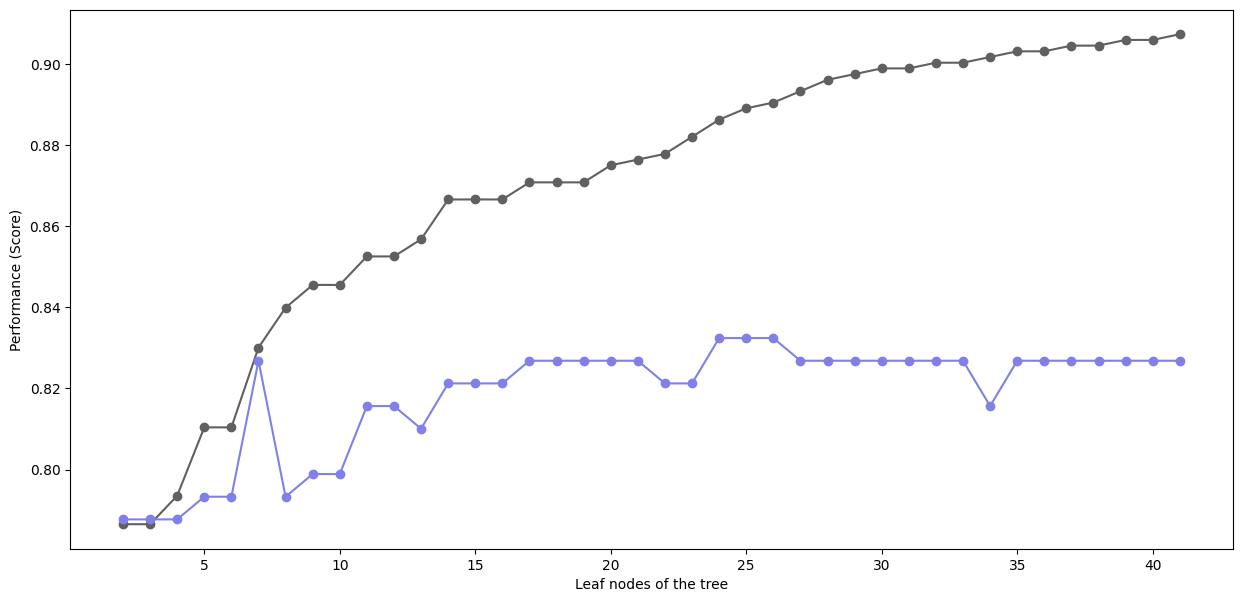

In [161]:
score_df = pd.DataFrame({'max_depth':range(2, 42), 'train_acc': train_accuracy, 'test_acc': test_accuracy})

plt.figure(figsize = (15,7))
plt.plot(score_df['max_depth'], score_df['train_acc'], marker = 'o', color = '#606060')
plt.plot(score_df['max_depth'], score_df['test_acc'], marker = 'o', color = '#8080e8')
plt.xlabel('Leaf nodes of the tree')
plt.ylabel('Performance (Score)')
plt.show()

In [162]:
print(dt_model.score(X_data, Y_data))
print(dt_model.score(X_data_test, Y_data_test))

0.9073033707865169
0.8268156424581006


In [179]:
# Changing max_features
max_leaf_nodes = 26

train_accuracy = []
test_accuracy = []
for depth in range(1, 20):
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, max_features=depth,random_state=156)
    dt_model.fit(X_data, Y_data)
    train_accuracy.append(dt_model.score(X_data, Y_data))
    test_accuracy.append(dt_model.score(X_data_test, Y_data_test))

In [180]:
print(train_accuracy)
print(test_accuracy)

[0.8342696629213483, 0.8286516853932584, 0.8412921348314607, 0.8735955056179775, 0.8693820224719101, 0.8778089887640449, 0.8778089887640449, 0.8862359550561798, 0.8862359550561798, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472, 0.8904494382022472]
[0.7988826815642458, 0.7877094972067039, 0.7821229050279329, 0.8435754189944135, 0.8268156424581006, 0.8212290502793296, 0.8268156424581006, 0.8268156424581006, 0.7932960893854749, 0.8212290502793296, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715, 0.8324022346368715]


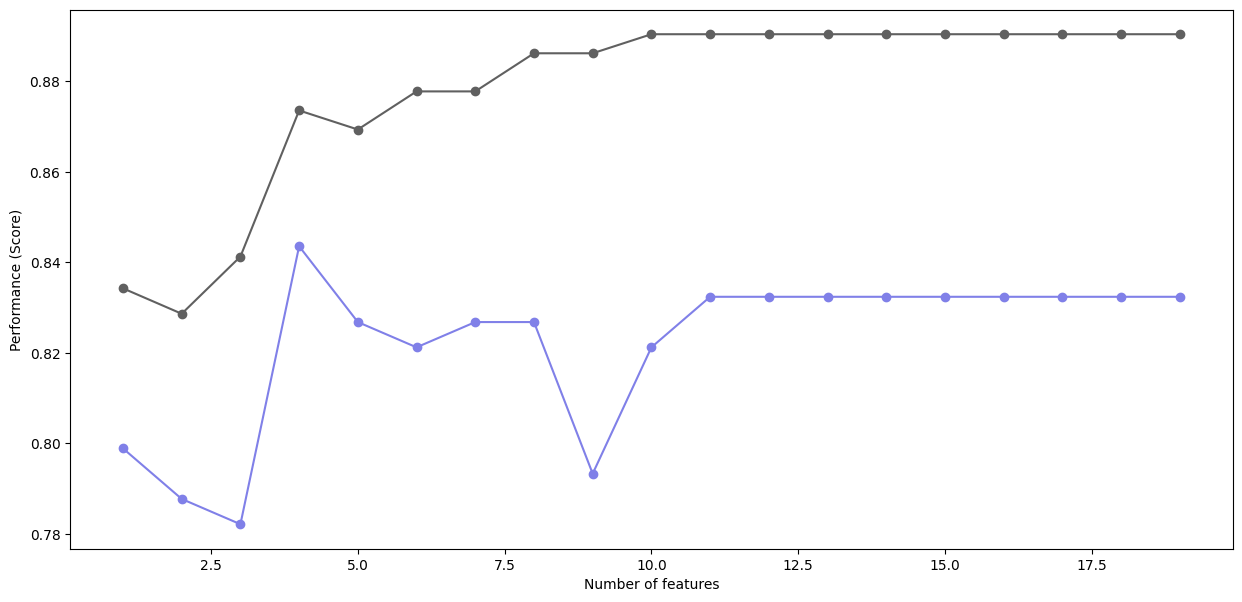

In [182]:
score_df = pd.DataFrame({'max_depth':range(1, 20), 'train_acc': train_accuracy, 'test_acc': test_accuracy})

plt.figure(figsize = (15,7))
plt.plot(score_df['max_depth'], score_df['train_acc'], marker = 'o', color = '#606060')
plt.plot(score_df['max_depth'], score_df['test_acc'], marker = 'o', color = '#8080e8')
plt.xlabel('Number of features')
plt.ylabel('Performance (Score)')
plt.show()

In [183]:
print(dt_model.score(X_data, Y_data))
print(dt_model.score(X_data_test, Y_data_test))

0.8904494382022472
0.8324022346368715


In [187]:
predictions = dt_model.predict(X_data_final_test)

final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv', index=False)

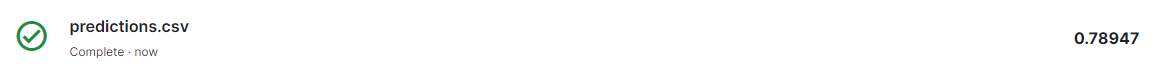